In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse as up
from tqdm import tqdm_notebook as tqdm
from time import sleep
import re
import warnings
import pickle as pkl
warnings.filterwarnings('ignore')
%matplotlib notebook

In [2]:
#GOALS

    #Data Cleaning and Retrieval
        #1. Retrieve Squad list from transfermarkt (of a particular season)
        #2. Injury data of all players from that season or from previous seasons
        #3. Get data likewise for other teams too
        
    #Data Visualizing and Interpretation
        
        #1. 2018/19 Season
            #a. Most Days Out (Done, Graph)
            #b. Most Number of Injuries (Done, Text)
            #c. Months where most number of injuries (Done, Graph)
            #d. Most common type of injuries (Done, Text)
            #e. Injuries which caused longest time in Sidelines (Done, Graph)
            #f. 
            

            #(For another thread)
            # Comparing no. (and length of injuries) with the Top 6
            
        #2. From 2013/14 to 2018/19 Season (MUFC Players only)
        
            #Parameters:
                #Only Seasons in the specified range
                #Only players in an MUFC Shirt
        
            #a. Months where most number of injuries take place
            #b. Players who had
                #i. most number of injuries(in an MUFC Shirt)
                #ii. missed most days (in an MUFC Shirt)
            #c. Most Injury Free Player 
                    #i. Least Injured (in an MUFC Shirt)
                    #ii. Least Number of days out (in an MUFC Shirt)
            #d. Most common type of Injury
            
        #3. Top 6 (2018/19) in the Premier League comparison
        
            #Preparation : Get the data and the Links
            #Parameters:
                #All stats per Team (unless mentioned)
                #All stats for 18/19 Season, only for players who played for said Team (i.e no Loanees)
                
            #a. Days Out per Team
            #b. Most Number of Injuries
            #b. Months where most Injuries 

## Data Retrieval

In [3]:
#parameter to control season
SAISON_ID = '2018'

#BASE_URL
BASE_URL = 'https://www.transfermarkt.com'

#TEAM BASE URL
TEAM_URL = 'https://www.transfermarkt.com/manchester-united/startseite/verein/985?'
#TEAM_URL = 'https://www.transfermarkt.com/tottenham-hotspur/startseite/verein/148?'


SORT_LINKS = {
    'class' : 'spielprofil_tooltip'
}

INJURY_URL = 'verletzungen'

HEADERS = {
    'User-Agent': 'Mozilla/5.0',
    'Accept': 'Accept: application/json, text/javascript, */*; q=0.01',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

MUFC_DATA = 'mufc_curent_squad_injury_history'

PROXY = {
  "http": None,
  "https": None,
}

PL_URL = 'https://www.transfermarkt.co.uk/premier-league/startseite/wettbewerb/GB1'

NUM_SEASONS = 6

In [6]:
def get_player_links(url, season):

    TEAM_SEASON_URL = url + up.urlencode({'saison_id': season})


    cnt = 0
    response = ''
    while response == '':
        try:
            response = requests.get(TEAM_SEASON_URL, headers = HEADERS, proxies = PROXY)
        except:
            cnt += 1
            print('Failed Connection ' + str(cnt))
            sleep(0.2)
            continue
    soup = BeautifulSoup(response.text, "html.parser")
    
    #Find only those with links to profile
    player_links = soup.find_all('a', SORT_LINKS)
    
    links = {}
    #Create a dictionary
    for link in player_links:
        links[link['title']] = BASE_URL + link['href']
    
    
    response.connection.close()
    return links

def get_injury_links(links):
    
    injury_links = links.copy()
    
    #modify links of players
    for player in injury_links.keys():
        
        link = injury_links[player]
        
        #Get the url containing path
        part_url = up.urlsplit(link)[2]
        part_vals = part_url.split('/')
        
        #modify to injury stats page
        part_vals[2] = INJURY_URL
        
        injury_links[player] = BASE_URL + '/'.join(part_vals)
        
    return injury_links

def get_season_format(val):
    start = val[-2:]
    end = str(int(val[-2:]) + 1)
    
    return start + '/' + end

def get_player_df(link, name , team):
    
    response = ''
    while response == '':
        try:
            response = requests.get(link, headers = HEADERS, verify = False, proxies = PROXY)
        except:
            sleep(0.2)
            continue
    soup = BeautifulSoup(response.text, "html.parser")
    
    #Get injury for all seasons, the date it occured and date of returning to action
    #no. of days out, #no. of games missed
    
    #season, dates
    date_links = soup.find_all(lambda tag: tag.name == 'td' and tag.get('class') == ['zentriert'])
    injury_links = soup.findAll(lambda tag: tag.name == 'td' and tag.get('class') == ['hauptlink'])
    days_links = soup.findAll(lambda tag: tag.name == 'td' and tag.get('class') == ['rechts'])

    
    games_links = soup.find_all('td', class_ = ['rechts hauptlink wappen_verletzung'])
    
    
    season_list = []
    from_list = []
    to_list = []
    injuries = []
    days_out = []
    games_out = []
    
    for i in range(0,len(date_links), 3):
        season_list = season_list + [str(date_links[i].string)]
        from_list = from_list + [str(date_links[i+1].string)]
        to_list = to_list + [str(date_links[i+2].string)]
            
    injuries = [str(elem.string) for elem in injury_links]
    days_out = [int(''.join(p for p in str(elem.string) if p.isdigit())) for elem in days_links]
    
    for elem in games_links:
        text = elem.get_text()
        if text == '-' or text == '?':
            games_out = games_out + [0]
        else:
            games_out = games_out + [int(elem.get_text())]
            
     
    #curr_team = []

    #Some players might be on loan, so get the team info when injurey happened
    #team_links = soup.find_all('img', class_ = ['tiny_wappen'])
    #for link in team_links:
    #    nm = link.get('alt')
    #    curr_team = curr_team + [str(nm)]
           
    curr_team = []

    games_links = soup.find_all('td', class_ = ['rechts hauptlink wappen_verletzung'])
    for link in games_links:

        if link.a is None:
            curr_team = curr_team + [team]
        else:
            tm = str(link.a.img['alt'])
            curr_team = curr_team + [tm]
    
    
    
    #print(games_links, games_out)
    df = pd.DataFrame({
        
        'Current Team': [team]*len(season_list),
        'Name': [name]*len(season_list),
        'Season' :season_list,
        'Injury' : injuries,
        'Date Injured':from_list,
        'Date Return':to_list,
        'Days Out':days_out,
        'Matches Out':games_out,
        'Team': curr_team
        
    })
    
    season = get_season_format(SAISON_ID)
    response.connection.close()
    return df

def get_complete_df(links, team_name):
    
    players = list(links.keys())
    
    data = []
    for i in tqdm(range(len(players))):
        
        #print(players[i])
        df = get_player_df(links[players[i]], str(players[i]), team_name)
        data = data + [df]
        
        
    return pd.concat(data, axis = 0)


def get_data(url, name, season):
    player_links = get_player_links(url, season)
    injury_links = get_injury_links(player_links)
    df = get_complete_df(injury_links, name)
    return df


def get_seasons_data(seasons_num, base_url, name):
    
    curr_season = int(SAISON_ID)
    seasons = [str(curr_season -i) for i in range(seasons_num)]
    
    data = []
    for i in tqdm(range(len(seasons))):
        print("Gathering Data for " + str(seasons[i]) + " Season")
        df = get_data(base_url, name, seasons[i])
        
        data = data + [df]
        
    return pd.concat(data, axis = 0)
        
    

In [17]:
df = get_data(TEAM_URL, 'Manchester United', SAISON_ID)
df.to_csv(MUFC_DATA+SAISON_ID+'.csv')

A Jupyter Widget

## MUFC 2018/19 Analysis

In [40]:
df = pd.read_csv(MUFC_DATA+SAISON_ID+'.csv', index_col= 0)
plot_df = plot_df[plot_df['Team'] == 'Manchester United']
plot_df = plot_df[plot_df['Season'] == '18/19']

In [41]:
SEASON_ORDER = [
    'July',
    'August',
    'September',
    'October',
    'November',
    'December',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June'
]

FONT_TITLE = "Arial Rounded MT Bold"
FONT_LABEL = "Franklin Gothic Medium"
FONT_TICK_LABELS = "Courier New"


def stylize_plot(ax, x_label, y_label, title):
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, family = FONT_TICK_LABELS)
    #ax.set_yticklabels(ax.get_yticklabels())
    
    ax.set_xlabel(x_label, family = FONT_LABEL , fontsize = 13)
    ax.set_ylabel(y_label, rotation = 90, family = FONT_LABEL, fontsize = 13)
    ax.set_title(title, family = FONT_TITLE, fontsize = 14)
    
    plt.tight_layout()
    
def init_plot(figsize, back):
    sns.set(rc={'figure.figsize':figsize})
    sns.set_style("darkgrid", {"axes.facecolor": back})
    sns.set_palette(sns.dark_palette("purple"))

<IPython.core.display.Javascript object>


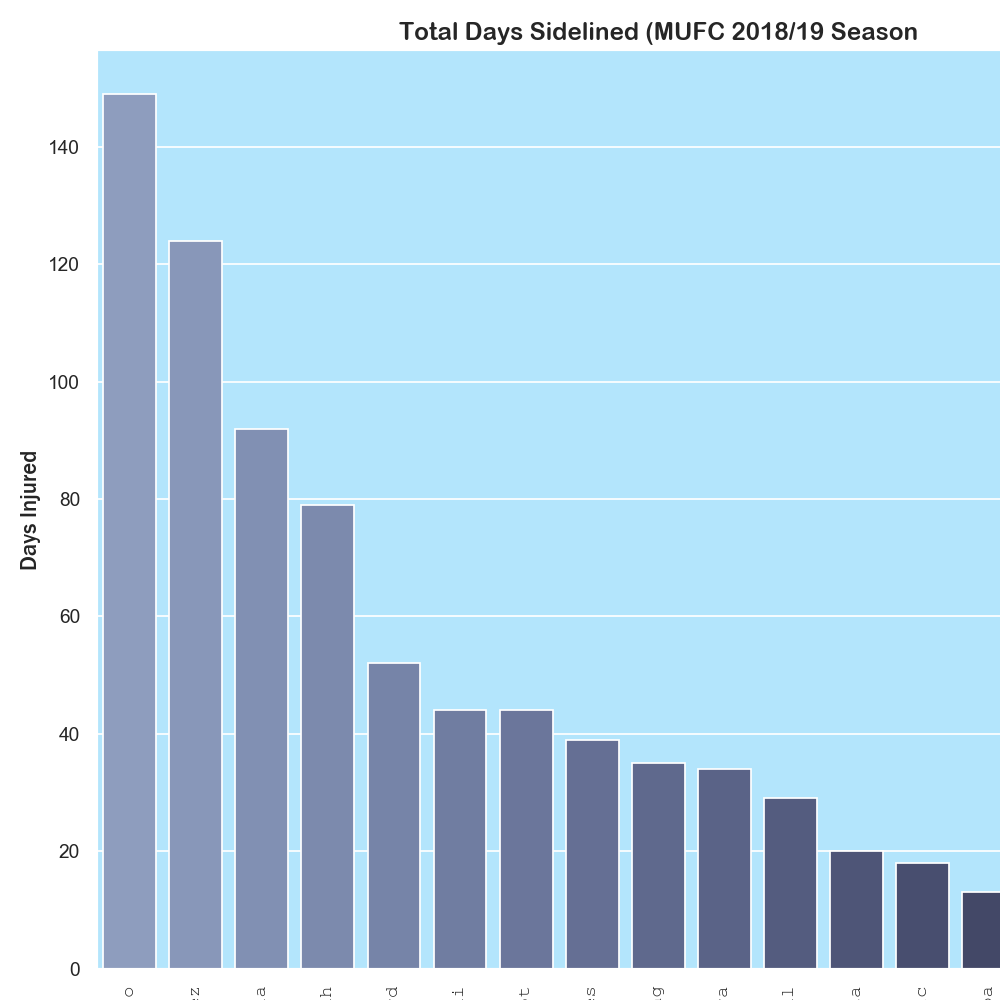

In [42]:
#1a Most Days Out

injury_series = plot_df[plot_df['Season'] == '18/19'].groupby(by = 'Name')['Days Out'].sum()
injury_series = injury_series.sort_values(ascending = False)
n = injury_series.shape[0]

fig = plt.figure()


init_plot((10, 10), "#b3e5fc")
ax = sns.barplot(injury_series.index, injury_series.values, palette= sns.color_palette("ch:3.0,-.1,light = 0.6, dark=.2", n_colors= n))
stylize_plot(ax, "Name" , "Days Injured", "Total Days Sidelined (MUFC 2018/19 Season")

fig.savefig('1a.jpg', dpi = 500)

In [43]:
#1b Most number of injuries

ij_count = plot_df.groupby('Name')['Injury'].count()
ij_count = ij_count.sort_values(ascending = False)

ij_count.head()
#fig = plt.figure()
#ax = sns.barplot(ij_count.index, ij_count.values)

Name
Alexis Sánchez      4
Antonio Valencia    3
Jesse Lingard       2
Phil Jones          2
Ander Herrera       2
Name: Injury, dtype: int64

<IPython.core.display.Javascript object>


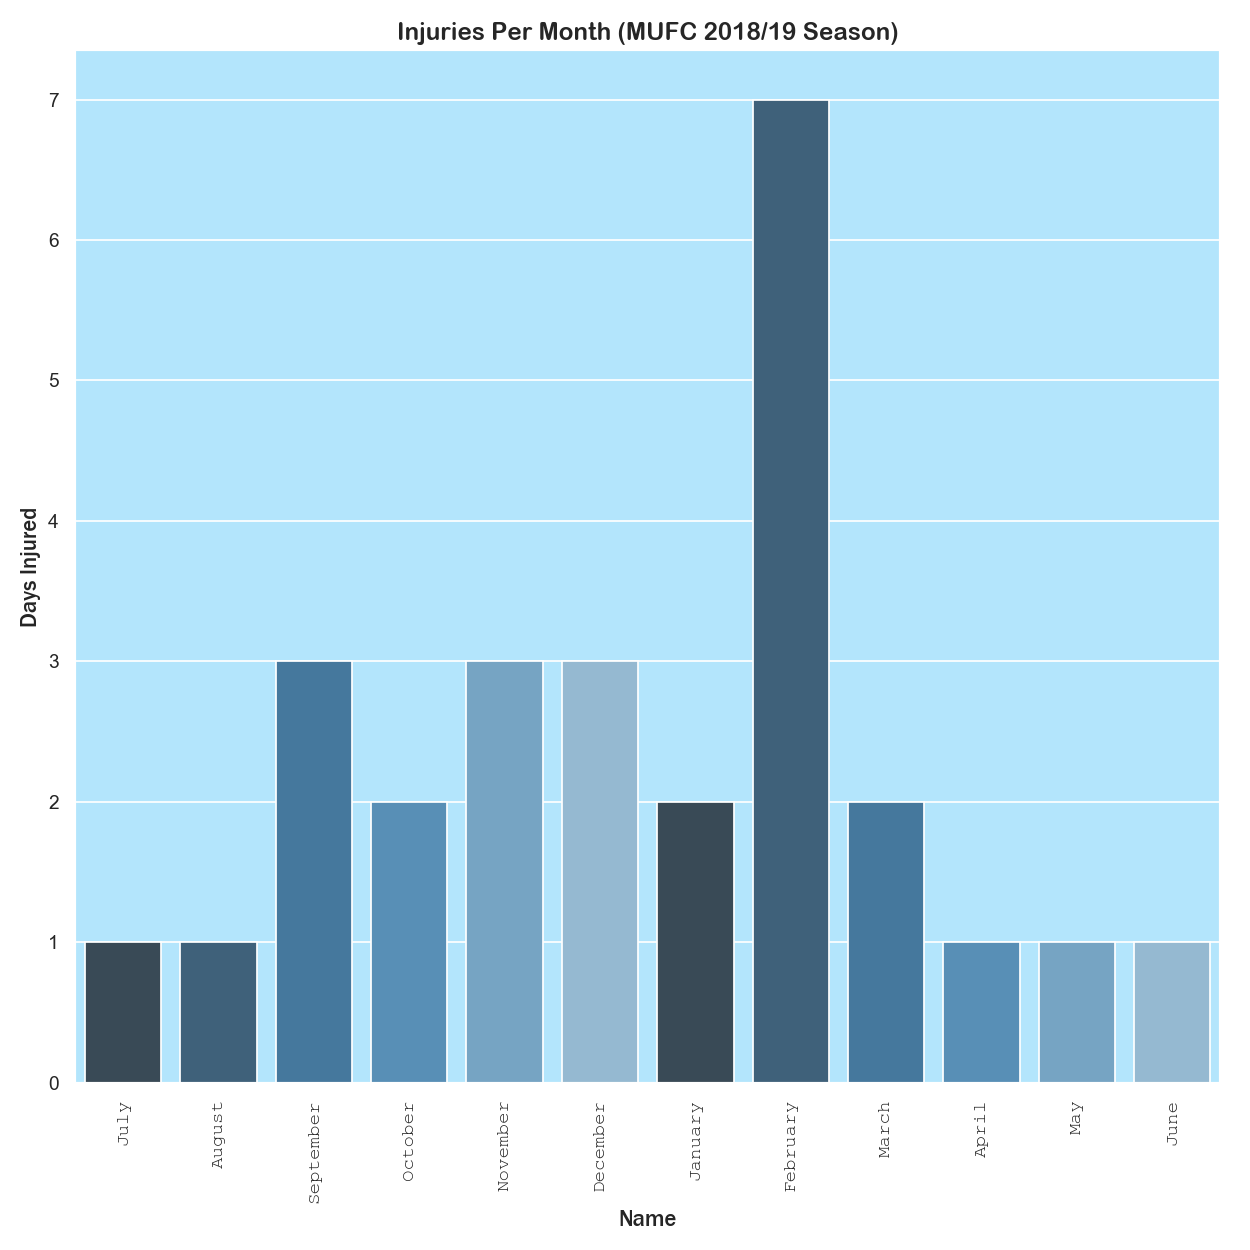

In [48]:
#1c Months where most Injuries

df['Date Injured'] = pd.to_datetime(df['Date Injured'])
df['Date Return'] = pd.to_datetime(df['Date Return'])

month_series = plot_df.reset_index()['Date Injured'].dt.month_name()
cnts = month_series.value_counts()

fig = plt.figure()

init_plot((10, 10), "#b3e5fc")
ax = sns.barplot(cnts.index, cnts.values, order= SEASON_ORDER, palette = sns.color_palette("Blues_d"))
stylize_plot(ax, "Name" , "Days Injured", "Injuries Per Month (MUFC 2018/19 Season)")

fig.savefig('1c.jpg', dpi = 500)

In [45]:
#1d Most Common Type of Injuries

cnts = plot_df['Injury'].value_counts()[:14]
cnts

Hamstring Injury             4
Knee Injury                  3
Calf Strain                  3
Ankle Injury                 3
Muscle Injury                3
Unknown Injury               2
Ill                          2
Concussion                   1
Hip problems                 1
groin strain                 1
Cruciate Ligament Surgery    1
Thigh Problems               1
Foot Injury                  1
Groin Injury                 1
Name: Injury, dtype: int64

<IPython.core.display.Javascript object>


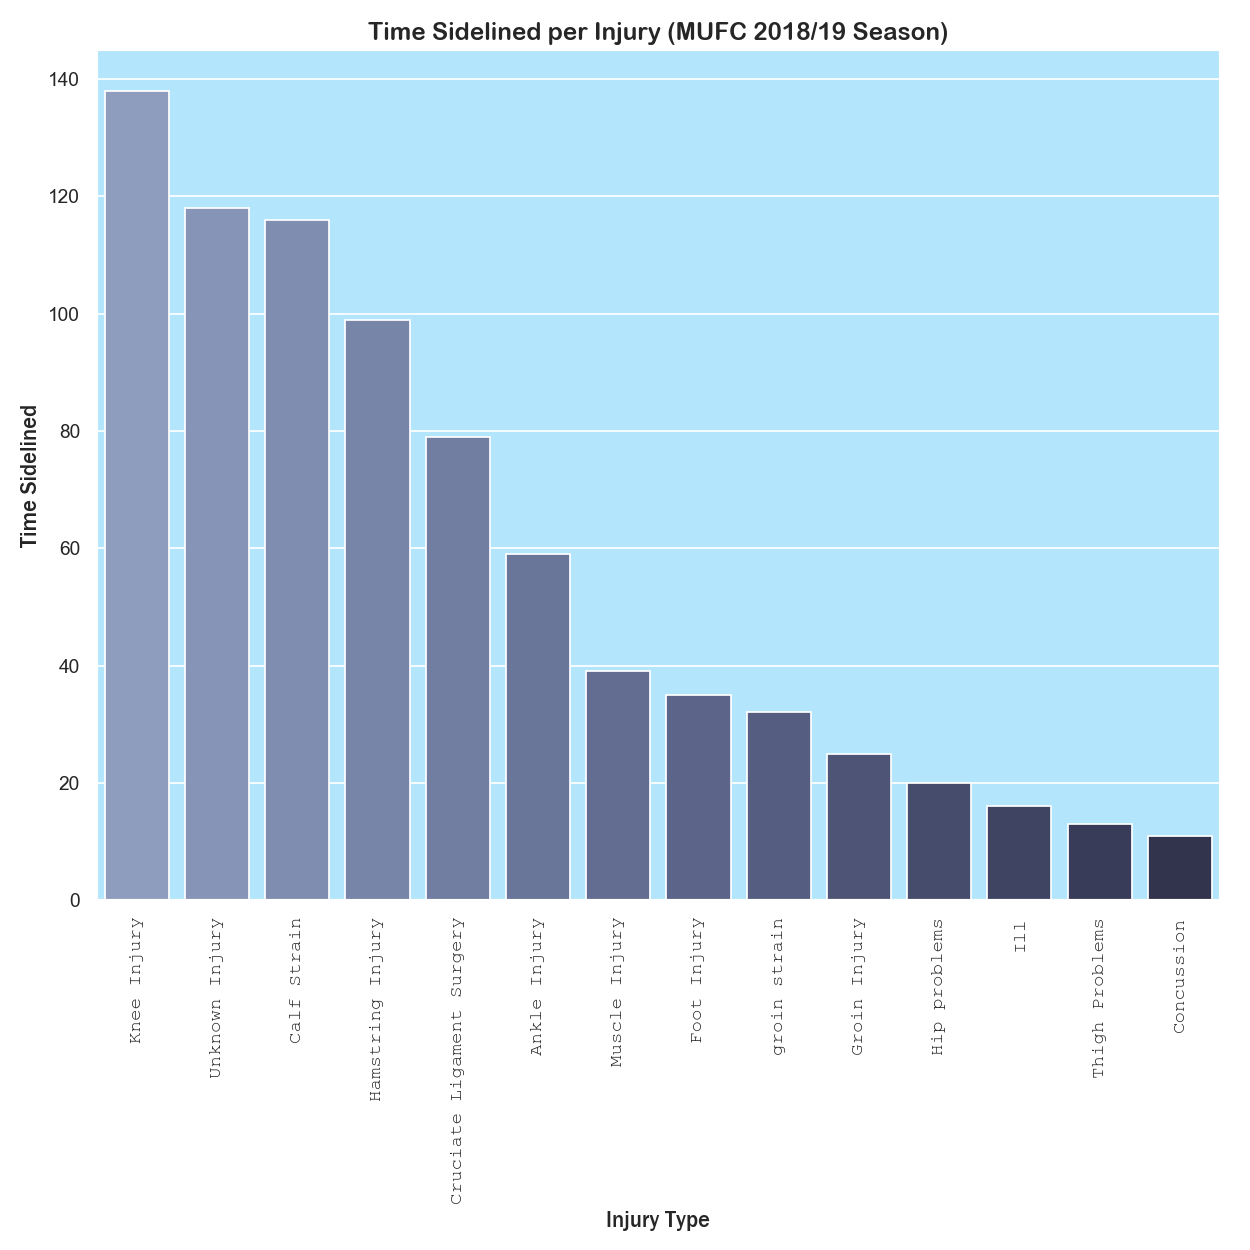

In [49]:
#1e Injuries which led to most days out

cnts = plot_df.groupby('Injury')['Days Out'].sum()
cnts = cnts.sort_values(ascending = False)
n = cnts.shape[0]

fig = plt.figure()

init_plot((10, 10), "#b3e5fc")
ax = sns.barplot(cnts.index, cnts.values, palette= sns.color_palette("ch:3.0,-.1,light = 0.6, dark=.2", n_colors= n))
stylize_plot(ax, "Injury Type" , "Time Sidelined", "Time Sidelined per Injury (MUFC 2018/19 Season)")
fig.savefig('1e.jpg', dpi = 500)

In [50]:
cnts

Injury
Knee Injury                  138.0
Unknown Injury               118.0
Calf Strain                  116.0
Hamstring Injury              99.0
Cruciate Ligament Surgery     79.0
Ankle Injury                  59.0
Muscle Injury                 39.0
Foot Injury                   35.0
groin strain                  32.0
Groin Injury                  25.0
Hip problems                  20.0
Ill                           16.0
Thigh Problems                13.0
Concussion                    11.0
Name: Days Out, dtype: float64

### Tweet Content

In [ ]:
# THREAD - Injury statistics of Manchester United players over the course of 2018/19 season.
# 
# Tweet 1
# Marcos Rojo and Alexis Sanchez have missed a combined total of 273 days (39 Matches) through injury.

# Tweet 2
# Alexis Sanchez has also had the most number of Injuries (4), followed by Antonio Valencia (3), Ander Herrera (2)
# and Marcos Rojo (2).

# Tweet 3
# Highest number of Injuries in February. Flashback to the midfield of Fred, Herrera, McTominay vs PSG.

# Tweet 4
# Hamstring and Knee Injuries were by far the most common type of Injuries.

# Tweet 5
# Knee Injuries and Calf Strains took by the longest time to recover.

# Tweet 6
# All data scraped from transfermarkt. A Top6 comparison + injury history post fergie era in the works.


#ManchesterUnited #MUFC #analytics #Transfers 

In [ ]:
#Reddit Content

# A few key points
# Marcos Rojo and Alexis Sanchez have missed a combined total of 273 days (39 Matches) through injury. 

# Tweet 2
# Alexis Sanchez has also had the most number of Injuries (4), followed by Antonio Valencia (3), Ander Herrera (2)
# and Marcos Rojo (2).

# Tweet 3
# Highest number of Injuries in February. Flashback to the midfield of Fred, Herrera, McTominay vs PSG.

# Tweet 4
# Hamstring and Knee Injuries were by far the most common type of Injuries.

# Tweet 5
# Knee Injuries and Calf Strains took by the longest time to recover.

# Tweet 6
# All data scraped from transfermarkt. A Top6 comparison + injury history post fergie era in the works.


## MUFC Post Fergie (6 Seasons) Analysis

In [6]:
season_df = get_seasons_data(NUM_SEASONS, TEAM_URL, 'Manchester United')
season_df.to_csv('Past ' + str(NUM_SEASONS) + ' Seasons Raw Data.csv')

A Jupyter Widget

Gathering Data for 2018 Season


A Jupyter Widget

Gathering Data for 2017 Season


A Jupyter Widget

Gathering Data for 2016 Season


A Jupyter Widget

Gathering Data for 2015 Season


A Jupyter Widget

Gathering Data for 2014 Season


A Jupyter Widget

Gathering Data for 2013 Season


A Jupyter Widget

In [10]:
clean_df = season_df.drop_duplicates()
mufc_df = clean_df[clean_df['Team'] == 'Manchester United']

<IPython.core.display.Javascript object>


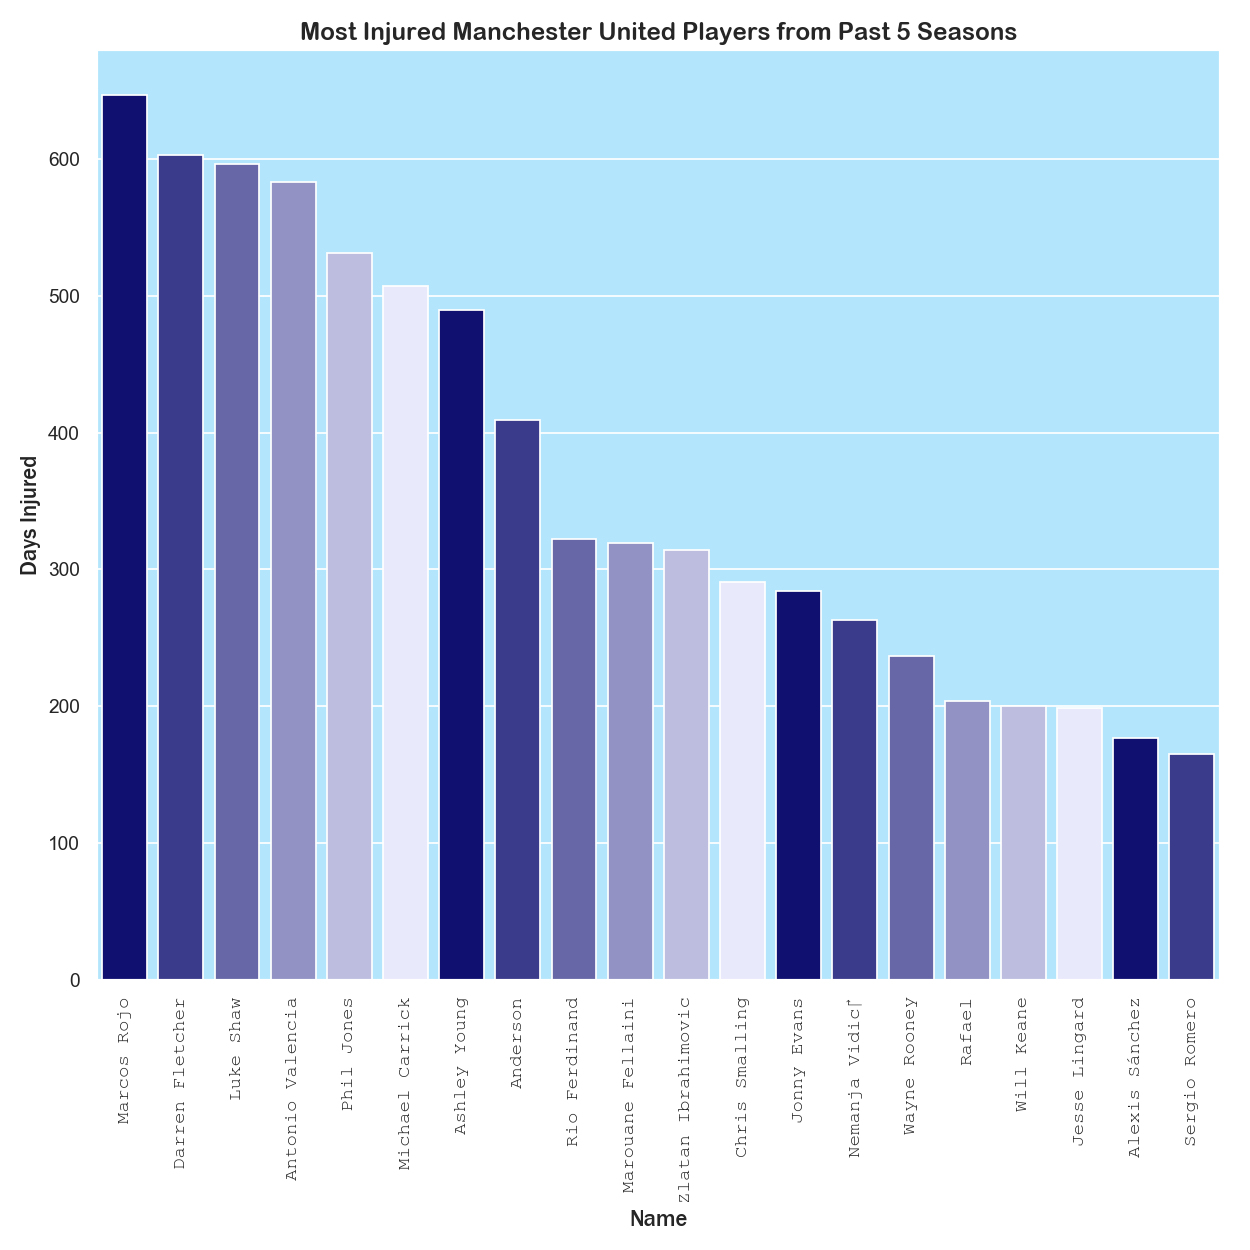

In [15]:
s_df = mufc_df.copy()

injury_series = s_df.groupby(by = 'Name')['Days Out'].sum()
injury_series = injury_series.sort_values(ascending = False)

fig = plt.figure()


init_plot((10, 10), "#b3e5fc")
ax = sns.barplot(injury_series[:20].index, injury_series[:20].values, palette= sns.light_palette("navy", reverse=True))
stylize_plot(ax, "Name" , "Days Injured", "Most Injured Manchester United Players from Past 5 Seasons")

<IPython.core.display.Javascript object>


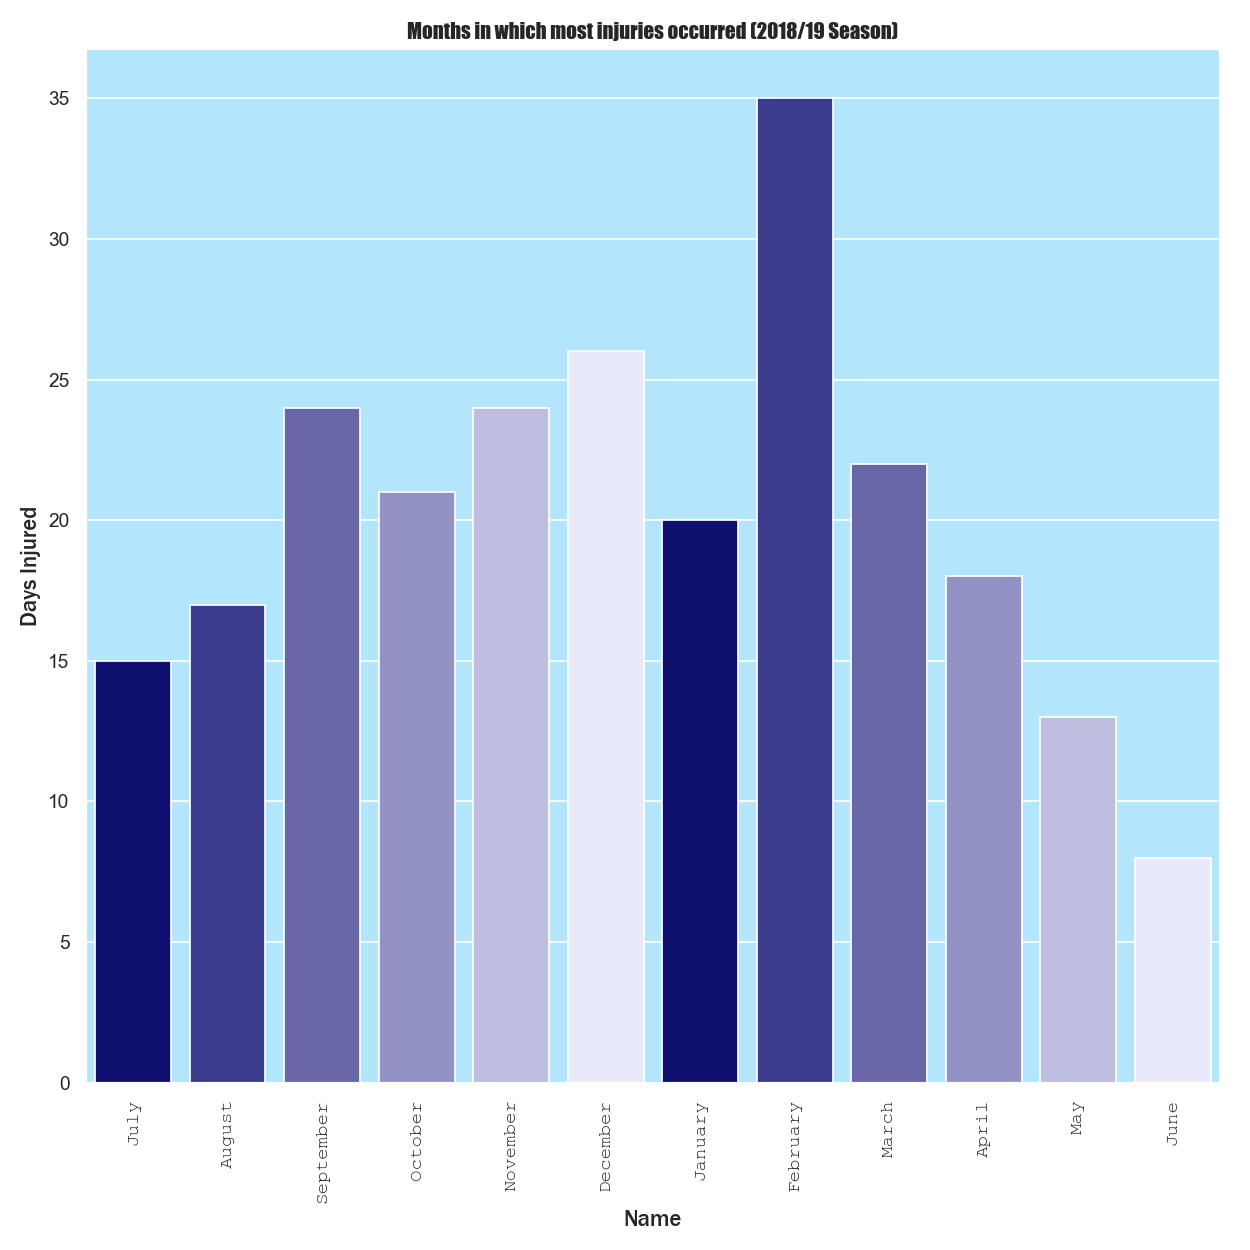

In [132]:
s_df = mufc_df.copy()

#Calculating months in which most injured

s_df['Date Injured'] = pd.to_datetime(s_df['Date Injured'])
s_df['Date Return'] = pd.to_datetime(s_df['Date Return'])

month_series = s_df.reset_index()['Date Injured'].dt.month_name()
cnts = month_series.value_counts()

plt.figure()

init_plot((10, 10), "#b3e5fc")
ax = sns.barplot(cnts.index, cnts.values, order= SEASON_ORDER, palette = sns.light_palette("navy", reverse=True))
stylize_plot(ax, "Name" , "Days Injured", "Months in which most injuries occurred (2018/19 Season)")

In [133]:
mufc_df[mufc_df['Name'] == 'Danny Welbeck']

,Current Team,Name,Season,Injury,Date Injured,Date Return,Days Out,Matches Out,Team
7,Manchester United,Danny Welbeck,14/15,Knee Problems,"Mar 30, 2015","Apr 2, 2015",3.0,0.0,Manchester United
8,Manchester United,Danny Welbeck,11/12,Torn Muscle Fibre,"Aug 29, 2011","Sep 19, 2011",21.0,3.0,Manchester United
10,Manchester United,Danny Welbeck,09/10,Knee Injury,"Mar 25, 2010","May 31, 2010",67.0,9.0,Manchester United
11,Manchester United,Danny Welbeck,09/10,Knee Problems,"Nov 19, 2009","Dec 10, 2009",21.0,6.0,Manchester United


## Top 6 Comparison

In [7]:
LINKS = {
    
    'Manchester City' : 'https://www.transfermarkt.com/manchester-city/startseite/verein/281?',
    'Liverpool FC': 'https://www.transfermarkt.com/fc-liverpool/startseite/verein/31?',
    'Chelsea FC': 'https://www.transfermarkt.com/fc-chelsea/startseite/verein/631?',
    'Tottenham Hotspur': 'https://www.transfermarkt.com/tottenham-hotspur/startseite/verein/148?',
    'Arsenal FC':'https://www.transfermarkt.com/fc-arsenal/startseite/verein/11?',
    'Manchester United' : 'https://www.transfermarkt.com/manchester-united/startseite/verein/985?',
}

In [8]:
raw_dfs = {}
teams = LINKS.keys()

for team in teams:
    print('Getting data for {}'.format(team))
    raw_dfs[team] = get_data(LINKS[team], team, SAISON_ID)

with open('raw_top_6_dfs.pkl', 'wb') as output_file:
    pkl.dump(raw_dfs, output_file)

Getting data for Manchester City


A Jupyter Widget


Getting data for Liverpool FC


A Jupyter Widget


Getting data for Chelsea FC


A Jupyter Widget


Getting data for Tottenham Hotspur


A Jupyter Widget


Getting data for Arsenal FC


A Jupyter Widget


Getting data for Manchester United


A Jupyter Widget

In [86]:
with open('raw_top_6_dfs.pkl', 'rb') as input_file:
    raw_dfs = pkl.load(input_file)

dfs = raw_dfs.values()
top6_df = pd.concat(dfs)

#Current Team == Team
#Season is only 18/19
#Reset Index

top6_df = top6_df[top6_df['Current Team'] == top6_df['Team']]
top6_df = top6_df[top6_df['Season'] == '18/19']
top6_df = top6_df.reset_index(drop = True)

In [87]:
#3a

#Find player who missed most days per Team

top6_df.groupby('Team')['Days Out'].sum()

Team
Arsenal FC            887.0
Liverpool FC          603.0
Manchester City      1028.0
Manchester United     800.0
Tottenham Hotspur    1263.0
Name: Days Out, dtype: float64